In [1]:
import glob
import os
import pandas as pd
# Numpy for numpy.arrays
import numpy as np

# Include ITK for DICOM reading.
import itk

# Include pydicom_seg for DICOM SEG objects
import pydicom
import pydicom_seg

# for downloading data from TCIA
from tcia_utils import nbia

# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# imports for monai
import torch
from monai.data import decollate_batch
from monai.bundle import ConfigParser, download
from monai.config import print_config

import SimpleITK as sitk
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle


import seaborn as sns

2024-04-10 08:57:34,032:WARNING:From c:\Users\Joel Fischer\.conda\envs\segmentationenv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



 Import the IOU of the pooled segmentations:

In [2]:
with open(f"C:/Users/Joel Fischer/Documents/Masterarbeit/Studie/Projekt/Auswertungsdaten/Benchmark/Lesion_wise_analysis/IoU_combined_segmentations.pickle","rb") as f:
    IoU_Case_dataframe_list = pickle.load(f)

In [3]:
with open(f"C:/Users/Joel Fischer/Documents/Masterarbeit/Studie/Projekt/Auswertungsdaten/Benchmark/Lesion_wise_analysis/DSC_combined_segmentations.pickle","rb") as f:
    DSC_Case_dataframe_list = pickle.load(f)

In [4]:
with open(f"C:/Users/Joel Fischer/Documents/Masterarbeit/Studie/Projekt/Auswertungsdaten/Benchmark/Lesion_wise_analysis/betascore_combined_segmentations.pickle","rb") as f:
    betascore_Case_dataframe_list = pickle.load(f)

In [5]:
translation = pd.read_excel('C:\\Users\\Joel Fischer\\Documents\\Masterarbeit\\Studie\\Projekt\\Auswertungsdaten\\Benchmark\\translation.xlsx')
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
translation.drop(8,inplace=True) #remove the bell_0027 case as its metadata is missing. 


# Plot the IOU values for every Reader vs the Fuse-AI prediction:

 Create a Dataframe with the information we need for the plot:

In [6]:
Reader_vs_AI_table = pd.DataFrame(columns=['IoU','DSC','beta_score','case','site','Reader','annotation_type','lesion'])

Cases = list(translation['Case'])
Cases.append('bell_0045')

for Case in Cases:
    Case_name = Case + '_IoU'
    IoU_Case_table = IoU_Case_dataframe_list[Case_name]
    DSC_Case_table = DSC_Case_dataframe_list[Case_name]
    betascore_Case_table = betascore_Case_dataframe_list[Case_name]
    
    for colname in IoU_Case_table.index:
        if colname != IoU_Case_table.columns[0]:
            IoU_value = IoU_Case_table.loc[IoU_Case_table.columns[0],colname]
            DSC_value = DSC_Case_table.loc[DSC_Case_table.columns[0],colname]
            betascore_value = betascore_Case_table.loc[betascore_Case_table.columns[0],colname]

            if IoU_value == 'no_comparison':
                lesion = False
            if IoU_value != 'no_comparison':
                lesion = True
            site = colname.split('_')[0]
            Reader = colname.split('_')[2] + '_' + colname.split('_')[3]
            annotation_type = colname.split('_')[3]
            Reader_vs_AI_table.loc[colname] = [IoU_value,DSC_value,betascore_value,Case,site, Reader, annotation_type, lesion]

 Remove the lesions which do not exists ('no_comparison'):

In [7]:
Reader_vs_AI_table = Reader_vs_AI_table[Reader_vs_AI_table['IoU'] != 'no_comparison']

In [100]:
betascore_Case_dataframe_list['bell_0001_IoU']

,bell_0001_fuseai,bell_0001_rad1_rad,bell_0001_rad1_ass,bell_0001_rad2_rad,bell_0001_rad2_ass,bell_0001_rad3_rad,bell_0001_rad3_ass
bell_0001_fuseai,1.0,0.197,0.211,0.13,0.105,no_comparison,no_comparison
bell_0001_rad1_rad,0.061,1.0,0.872,0.576,0.606,no_comparison,no_comparison
bell_0001_rad1_ass,0.064,0.821,1.0,0.6,0.632,no_comparison,no_comparison
bell_0001_rad2_rad,0.036,0.384,0.423,1.0,0.86,no_comparison,no_comparison
bell_0001_rad2_ass,0.029,0.367,0.404,0.775,1.0,no_comparison,no_comparison
bell_0001_rad3_rad,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison
bell_0001_rad3_ass,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison


# Comparison between pooled Fuse-AI prediction and pooled predictions for each reader

In [8]:

#make colormap for annotation types:
cmap = plt.cm.get_cmap('viridis')
bell_color = cmap(0.1)
ksa3_color = cmap(0.3)
tri_color = cmap(0.6)

#colormap for piquals:
cmap = plt.cm.get_cmap('cividis')
piqual3_color = cmap(0.1)
piqual_3_and_4_color = cmap(0.3)
piqual4_color = cmap(0.6)
piqual5_color = cmap(0.9)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


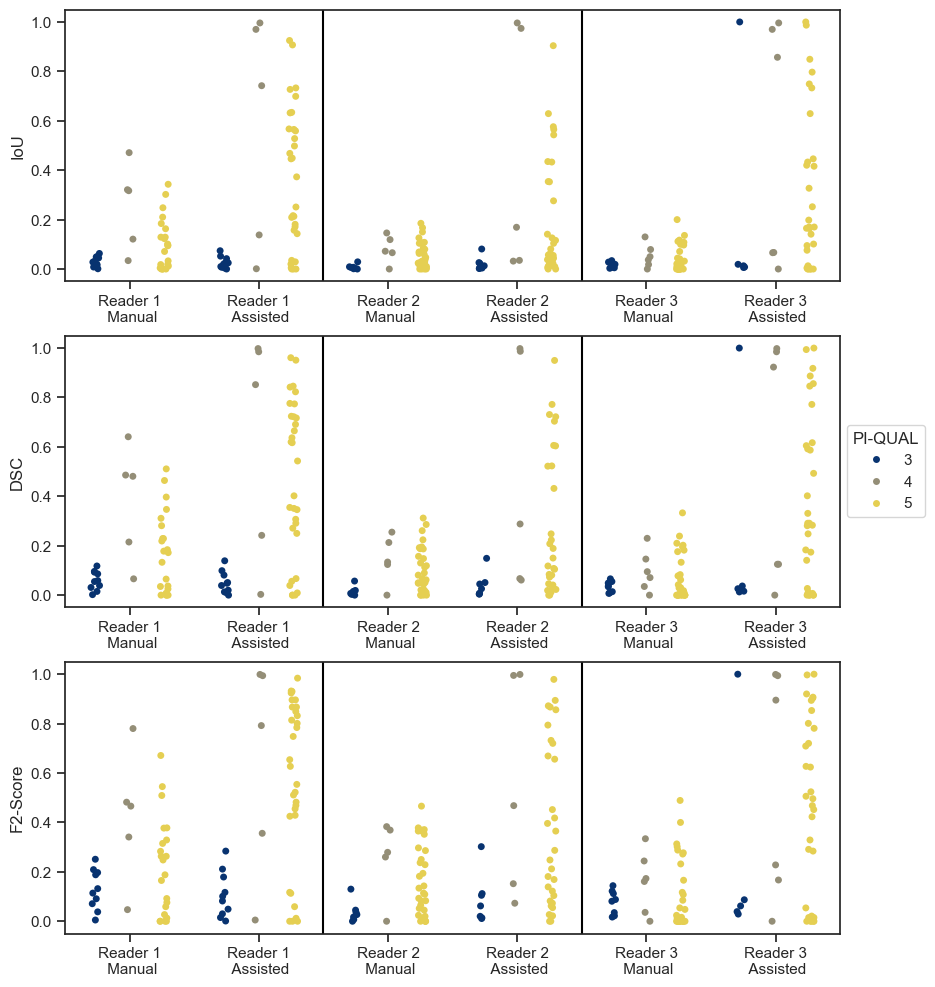

In [95]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,figsize=(10,12))

#fig.suptitle('Comparison between pooled Fuse-AI prediction and pooled predictions for each reader',size=17)
#All lesions of a Case and Reader are pooled and compare with the pooled prediction
#Create boxplots:
sns.set_theme(style="ticks")

sns.stripplot(ax=ax1, x="Reader", y="IoU",
            hue="PI-QUAL", palette=[piqual3_color,piqual4_color,piqual5_color],  data=Reader_vs_AI_table, dodge=True)
sns.stripplot(ax=ax2, x="Reader", y="DSC",
            hue="PI-QUAL", palette=[piqual3_color,piqual4_color,piqual5_color],  data=Reader_vs_AI_table, dodge=True)

sns.stripplot(ax=ax3, x="Reader", y="beta_score",
            hue="PI-QUAL", palette=[piqual3_color,piqual4_color,piqual5_color],  data=Reader_vs_AI_table, dodge=True)
ax1.axvline(x=1.5, color='black')
ax1.axvline(x=3.5, color='black')
ax2.axvline(x=1.5, color='black')
ax2.axvline(x=3.5, color='black')
ax3.axvline(x=1.5, color='black')
ax3.axvline(x=3.5, color='black')

ax1.set_xticklabels(['Reader 1\n Manual','Reader 1\n Assisted','Reader 2\n Manual','Reader 2\n Assisted','Reader 3\n Manual','Reader 3\n Assisted'])
ax2.set_xticklabels(['Reader 1\n Manual','Reader 1\n Assisted','Reader 2\n Manual','Reader 2\n Assisted','Reader 3\n Manual','Reader 3\n Assisted'])
ax3.set_xticklabels(['Reader 1\n Manual','Reader 1\n Assisted','Reader 2\n Manual','Reader 2\n Assisted','Reader 3\n Manual','Reader 3\n Assisted'])

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax3.set_ylabel('F2-Score')
ax1.legend(title='')
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()

plt.legend(bbox_to_anchor=(1.12, 1.9),loc='upper right', title='PI-QUAL')

path = 'figures_lesion_overlap/IoU_DSC_f2.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

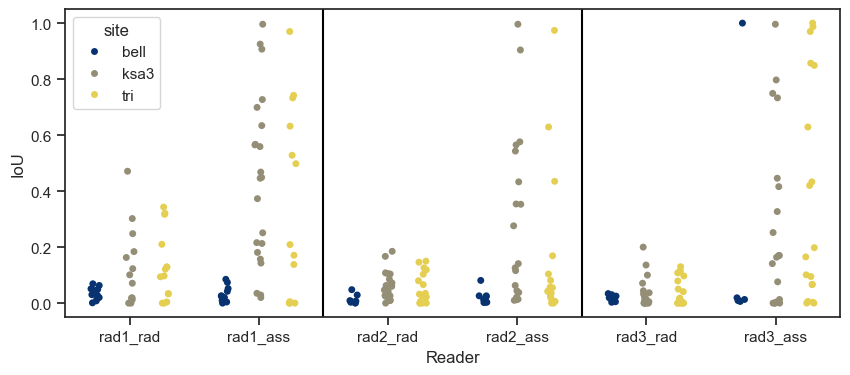

In [10]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,4))

#fig.suptitle('Comparison between pooled Fuse-AI prediction and pooled predictions for each reader',size=17)
#All lesions of a Case and Reader are pooled and compare with the pooled prediction
#Create boxplots:
sns.set_theme(style="ticks")

sns.stripplot(ax=ax1, x="Reader", y="IoU",
            hue="site", palette=[piqual3_color,piqual4_color,piqual5_color],  data=Reader_vs_AI_table, dodge=True)

ax1.axvline(x=1.5, color='black')
ax1.axvline(x=3.5, color='black')

path = 'figures_lesion_overlap/IoU.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

# Make the same plot but with different PI-QUAL scores

In [11]:
piquals =  pd.read_excel("C:/Users/Joel Fischer/Documents/Masterarbeit/Studie/Projekt/Auswertungsdaten/20230814_KSA-study_Image-Quality_Master.xlsx")
piquals.index = piquals['Case']

In [12]:
Reader_vs_AI_table['PI-QUAL'] = 'not_available'
for lesion in Reader_vs_AI_table.index:
    site = Reader_vs_AI_table.loc[lesion,'case'].split('_')[0] + '-' + Reader_vs_AI_table.loc[lesion,'case'].split('_')[1]
    if site != 'bell-0045':
        Reader_vs_AI_table.loc[lesion,'PI-QUAL'] = piquals.loc[site,'Image quality PI-QUAL']
    else:
        Reader_vs_AI_table.drop(lesion,inplace=True)

In [65]:
#counter for the different comparisons:

Readers = ['rad1_rad','rad1_ass','rad2_rad','rad2_ass','rad3_rad','rad3_ass']
piqual_scores = [3,4,5]

counts = pd.DataFrame(columns=piqual_scores,index=Readers)

for read in Readers:
    for scores in piqual_scores:
        counts.loc[read,scores] = Reader_vs_AI_table[(Reader_vs_AI_table['Reader'] == read) & (Reader_vs_AI_table['PI-QUAL'] == scores)].shape[0]

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


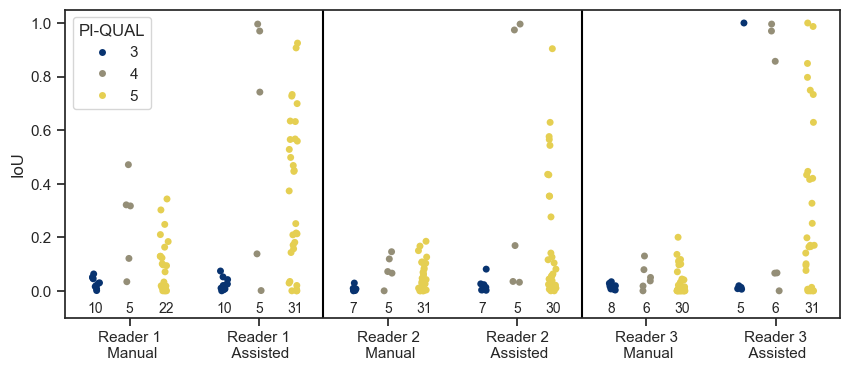

In [66]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,4))

#fig.suptitle('Comparison between pooled Fuse-AI prediction and pooled predictions for each reader',size=17)
#All lesions of a Case and Reader are pooled and compare with the pooled prediction
#Create boxplots:
sns.set_theme(style="ticks")

sns.stripplot(ax=ax1, x="Reader", y="IoU",
            hue="PI-QUAL", palette=[piqual3_color,piqual4_color,piqual5_color],  data=Reader_vs_AI_table, dodge=True)

ax1.axvline(x=1.5, color='black')
ax1.axvline(x=3.5, color='black')

ax1.set_xticklabels(['Reader 1\n Manual','Reader 1\n Assisted','Reader 2\n Manual','Reader 2\n Assisted','Reader 3\n Manual','Reader 3\n Assisted'])
ax1.set(ylim=(-0.1,1.05))
plt.xlabel('')

#plot the number of comparisons:
plt.text(x = -0.33, y = -0.08, s = f"{counts.loc['rad1_rad',3]}", size = 10)
plt.text(x = -0.33+0.3, y = -0.08, s = f"{counts.loc['rad1_rad',4]}", size = 10)
plt.text(x = -0.33+0.55, y = -0.08, s = f"{counts.loc['rad1_rad',5]}", size = 10)

plt.text(x = -0.33+1*1, y = -0.08, s = f"{counts.loc['rad1_ass',3]}", size = 10)
plt.text(x = -0.33+1*1+0.3, y = -0.08, s = f"{counts.loc['rad1_ass',4]}", size = 10)
plt.text(x = -0.33+1*1+0.55, y = -0.08, s = f"{counts.loc['rad1_ass',5]}", size = 10)

plt.text(x = -0.30+1*2, y = -0.08, s = f"{counts.loc['rad2_rad',3]}", size = 10)
plt.text(x = -0.33+1*2+0.3, y = -0.08, s = f"{counts.loc['rad2_rad',4]}", size = 10)
plt.text(x = -0.33+1*2+0.55, y = -0.08, s = f"{counts.loc['rad2_rad',5]}", size = 10)

plt.text(x = -0.30+1*3, y = -0.08, s = f"{counts.loc['rad2_ass',3]}", size = 10)
plt.text(x = -0.33+1*3+0.3, y = -0.08, s = f"{counts.loc['rad2_ass',4]}", size = 10)
plt.text(x = -0.33+1*3+0.55, y = -0.08, s = f"{counts.loc['rad2_ass',5]}", size = 10)

plt.text(x = -0.30+1*4, y = -0.08, s = f"{counts.loc['rad3_rad',3]}", size = 10)
plt.text(x = -0.33+1*4+0.3, y = -0.08, s = f"{counts.loc['rad3_rad',4]}", size = 10)
plt.text(x = -0.33+1*4+0.55, y = -0.08, s = f"{counts.loc['rad3_rad',5]}", size = 10)

plt.text(x = -0.30+1*5, y = -0.08, s = f"{counts.loc['rad3_ass',3]}", size = 10)
plt.text(x = -0.33+1*5+0.3, y = -0.08, s = f"{counts.loc['rad3_ass',4]}", size = 10)
plt.text(x = -0.33+1*5+0.55, y = -0.08, s = f"{counts.loc['rad3_ass',5]}", size = 10)

path = 'figures_lesion_overlap/IoU.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

# Similarity to AI-Tool

In [15]:
Reader_vs_AI_table_ass_minus_rad = pd.DataFrame(columns=['ass_IoU_minus_rad_IoU','ass_DSC_minus_man_DSc','ass_betascore_minus_man_betascore','case','site','Reader'])

Cases = list(translation['Case'])
Cases.append('bell_0045')

Readers = ['rad1','rad2','rad3']

for Case in Cases:
    Case_name = Case + '_IoU'
    IoU_Case_table = IoU_Case_dataframe_list[Case_name]
    DSC_Case_table = DSC_Case_dataframe_list[Case_name]
    betascore_Case_table = betascore_Case_dataframe_list[Case_name]
    site = IoU_Case_table.index[0].split('_')[0]

    #Calculate the Difference of the manual and assisted IoU per Reader:
    for Reader in Readers:
        rowname = f"{Case}_{Reader}"
        site = Case.split('_')[0]
        annotation_type = colname.split('_')[3]

        colname1 = f"{Case}_{Reader}_rad"
        colname2 = f"{Case}_{Reader}_ass"

        IoU_value_1 = IoU_Case_table.loc[IoU_Case_table.columns[0],colname1]
        IoU_value_2 = IoU_Case_table.loc[IoU_Case_table.columns[0],colname2]

        DSC_value_1 = DSC_Case_table.loc[DSC_Case_table.columns[0],colname1]
        DSC_value_2 = DSC_Case_table.loc[DSC_Case_table.columns[0],colname2]

        betascore_value_1 = betascore_Case_table.loc[betascore_Case_table.columns[0],colname1]
        betascore_value_2 = betascore_Case_table.loc[betascore_Case_table.columns[0],colname2]

        #If there is no lesion we don't calculate, and also if there is a division by 0:
        if IoU_value_1 != 'no_comparison' and IoU_value_2 != 'no_comparison': 
            man_IoU_over_ass_IoU = IoU_value_2 - IoU_value_1
            man_DSC_over_ass_DSc = DSC_value_2 - DSC_value_1
            man_betascore_over_ass_betascore = betascore_value_2 - betascore_value_1

        if IoU_value_1 == 'no_comparison' or IoU_value_2 == 'no_comparison':
            man_IoU_over_ass_IoU = 'no_comparison'
            man_DSC_over_ass_DSc = 'no_comparison'
            man_betascore_over_ass_betascore = 'no_comparison'

        Reader_vs_AI_table_ass_minus_rad.loc[rowname] = [man_IoU_over_ass_IoU,man_DSC_over_ass_DSc,man_betascore_over_ass_betascore,Case,site, Reader]

 Remove the ones with 'no_comparison' or 'divison_by_0'

In [16]:
Reader_vs_AI_table_ass_minus_rad = Reader_vs_AI_table_ass_minus_rad[Reader_vs_AI_table_ass_minus_rad['ass_IoU_minus_rad_IoU'] != 'no_comparison']

#Get piqual scores:
Reader_vs_AI_table_ass_minus_rad['PI-QUAL'] = 'not_available'
for lesion in Reader_vs_AI_table_ass_minus_rad.index:
    site = Reader_vs_AI_table_ass_minus_rad.loc[lesion,'case'].split('_')[0] + '-' + Reader_vs_AI_table_ass_minus_rad.loc[lesion,'case'].split('_')[1]
    if site != 'bell-0045':
        Reader_vs_AI_table_ass_minus_rad.loc[lesion,'PI-QUAL'] = piquals.loc[site,'Image quality PI-QUAL']
    else:
        Reader_vs_AI_table_ass_minus_rad.drop(lesion,inplace=True)

In [48]:
#counter for the different IoU Differences:

Readers = ['rad1','rad2','rad3']
piqual_scores = [3,4,5]

counts = pd.DataFrame(columns=piqual_scores,index=Readers)

for read in Readers:
    for scores in piqual_scores:
        counts.loc[read,scores] = Reader_vs_AI_table_ass_minus_rad[(Reader_vs_AI_table_ass_minus_rad['Reader'] == read) & (Reader_vs_AI_table_ass_minus_rad['PI-QUAL'] == scores)].shape[0]

In [50]:
counts

,3,4,5
rad1,9,4,16
rad2,5,5,26
rad3,3,6,25


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


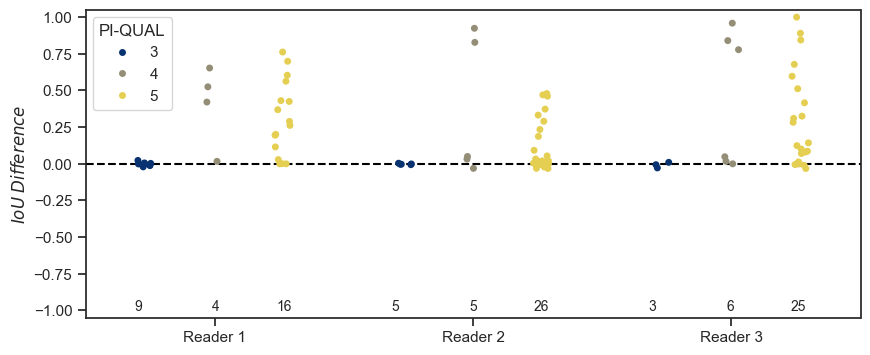

In [63]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(10,4))

#fig.suptitle('Difference in Intersection over union between manual and assisted annotation\n for each Case and each Reader',size=17)
#All lesions of a Case and Reader are pooled and compare with the pooled prediction
#Create boxplots:
sns.set_theme(style="ticks",palette=[piqual3_color,piqual4_color,piqual5_color])

sns.stripplot(ax = ax1, x="Reader", y="ass_IoU_minus_rad_IoU", hue='PI-QUAL',palette=[piqual3_color,piqual4_color,piqual5_color], data=Reader_vs_AI_table_ass_minus_rad, dodge=True)


ax1.axhline(y=0, color='black', linestyle='dashed')
ax1.set_xticklabels(['Reader 1','Reader 2','Reader 3'])
plt.ylabel(r'$IoU$ $Difference$')
plt.xlabel('')
ax1.set_ylim([-1.05, 1.05])

plt.text(x = -0.31, y = -1, s = f"{counts.loc['rad1',3]}", size = 10)
plt.text(x = -0.31+0.3, y = -1, s = f"{counts.loc['rad1',4]}", size = 10)
plt.text(x = -0.31+0.55, y = -1, s = f"{counts.loc['rad1',5]}", size = 10)

plt.text(x = -0.315+1, y = -1, s = f"{counts.loc['rad2',3]}", size = 10)
plt.text(x = -0.315+1+0.3, y = -1, s = f"{counts.loc['rad2',4]}", size = 10)
plt.text(x = -0.315+1+0.55, y = -1, s = f"{counts.loc['rad2',5]}", size = 10)

plt.text(x = -0.32+2, y = -1, s = f"{counts.loc['rad3',3]}", size = 10)
plt.text(x = -0.32+2+0.3, y = -1, s = f"{counts.loc['rad3',4]}", size = 10)
plt.text(x = -0.32+2+0.55, y = -1, s = f"{counts.loc['rad3',5]}", size = 10)


path = 'figures_lesion_overlap/IoU_Difference.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

# Comparison of Manual vs Assisted overlap:

In [18]:
Manual_vs_Assisted_table = pd.DataFrame(columns=['IoU','DSC','f_score','reader','case','site'])

Cases = list(translation['Case'])
Cases.append('bell_0045')

for Case in Cases:
    Case_name = Case + '_IoU'
    IoU_Case_table = IoU_Case_dataframe_list[Case_name]
    DSC_Case_table = DSC_Case_dataframe_list[Case_name]
    F_Case_table = betascore_Case_dataframe_list[Case_name]
    
    Reader1_IoU_value = IoU_Case_table.loc[f"{Case}_rad1_rad",f"{Case}_rad1_ass"]
    Reader1_DSC_value = DSC_Case_table.loc[f"{Case}_rad1_rad",f"{Case}_rad1_ass"]
    Reader1_f_value = F_Case_table.loc[f"{Case}_rad1_rad",f"{Case}_rad1_ass"]

    Reader2_IoU_value = IoU_Case_table.loc[f"{Case}_rad2_rad",f"{Case}_rad2_ass"]
    Reader2_DSC_value = DSC_Case_table.loc[f"{Case}_rad2_rad",f"{Case}_rad2_ass"]
    Reader2_f_value = F_Case_table.loc[f"{Case}_rad2_rad",f"{Case}_rad2_ass"]

    Reader3_IoU_value = IoU_Case_table.loc[f"{Case}_rad3_rad",f"{Case}_rad3_ass"]
    Reader3_DSC_value = DSC_Case_table.loc[f"{Case}_rad3_rad",f"{Case}_rad3_ass"]
    Reader3_f_value = F_Case_table.loc[f"{Case}_rad3_rad",f"{Case}_rad3_ass"]

    site = Case.split('_')[0]
    Manual_vs_Assisted_table.loc[f"{Case_name}_reader1"] = [Reader1_IoU_value,Reader1_DSC_value,Reader1_f_value,'reader1',Case,site]
    Manual_vs_Assisted_table.loc[f"{Case_name}_reader2"] = [Reader2_IoU_value,Reader2_DSC_value,Reader2_f_value,'reader2',Case,site]
    Manual_vs_Assisted_table.loc[f"{Case_name}_reader3"] = [Reader3_IoU_value,Reader3_DSC_value,Reader3_f_value,'reader3',Case,site]


In [19]:
#remove the cases with no comparison:
for i in Manual_vs_Assisted_table.index:
    if Manual_vs_Assisted_table.loc[i,'IoU'] == 'no_comparison':
        Manual_vs_Assisted_table.drop(i,inplace=True)

In [20]:
#Get piqual scores:
Manual_vs_Assisted_table['PI-QUAL'] = 'not_available'
for lesion in Manual_vs_Assisted_table.index:
    site = Manual_vs_Assisted_table.loc[lesion,'case'].split('_')[0] + '-' + Manual_vs_Assisted_table.loc[lesion,'case'].split('_')[1]
    if site != 'bell-0045':
        Manual_vs_Assisted_table.loc[lesion,'PI-QUAL'] = piquals.loc[site,'Image quality PI-QUAL']
    else:
        Manual_vs_Assisted_table.drop(lesion,inplace=True)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


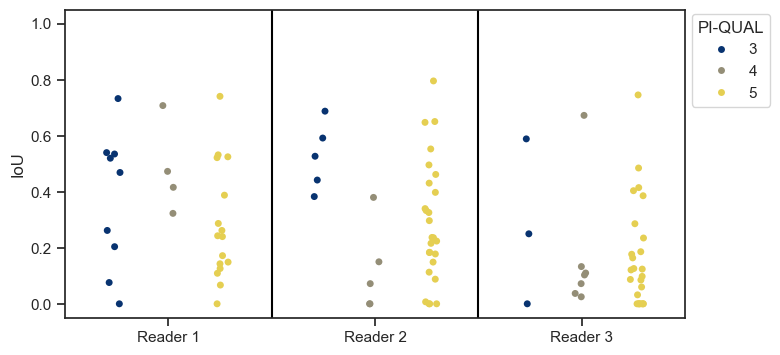

In [21]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(8,4))

#fig.suptitle('Comparison between pooled Fuse-AI prediction and pooled predictions for each reader',size=17)
#All lesions of a Case and Reader are pooled and compare with the pooled prediction
#Create boxplots:
sns.set_theme(style="ticks")

sns.stripplot(ax=ax1, x="reader", y="IoU", hue='PI-QUAL',
             palette=[piqual3_color,piqual4_color,piqual5_color],  data=Manual_vs_Assisted_table, dodge=True)

ax1.axvline(x=0.5, color='black')
ax1.axvline(x=1.5, color='black')

ax1.set_xticklabels(['Reader 1','Reader 2', 'Reader 3'])
ax1.set(ylim=(-0.05,1.05))
ax1.set_xlabel('')
plt.legend(bbox_to_anchor=(1.15, 1.01),loc='upper right', title='PI-QUAL')

In [23]:
IoU_Case_dataframe_list['bell_0001_IoU']

,bell_0001_fuseai,bell_0001_rad1_rad,bell_0001_rad1_ass,bell_0001_rad2_rad,bell_0001_rad2_ass,bell_0001_rad3_rad,bell_0001_rad3_ass
bell_0001_fuseai,1.0,0.049,0.052,0.029,0.023,no_comparison,no_comparison
bell_0001_rad1_rad,0.049,1.0,0.733,0.299,0.296,no_comparison,no_comparison
bell_0001_rad1_ass,0.052,0.733,1.0,0.33,0.327,no_comparison,no_comparison
bell_0001_rad2_rad,0.029,0.299,0.33,1.0,0.688,no_comparison,no_comparison
bell_0001_rad2_ass,0.023,0.296,0.327,0.688,1.0,no_comparison,no_comparison
bell_0001_rad3_rad,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison
bell_0001_rad3_ass,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison,no_comparison
